In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython import display

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [0]:
tf.enable_eager_execution()

In [4]:
%mkdir train_figs

mkdir: cannot create directory ‘train_figs’: File exists


# Genertaor

In [0]:
def generator():
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(7*7*64, use_bias=False, input_shape=(100,), 
                                  kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02)),
            tf.keras.layers.Reshape((7,7,64)),

            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
                                            kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02)),                                 
            
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same',
                                            kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02)),
                                 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same',
                                            kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02)),
                                 
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='tanh',
                                           kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02))
    ]) 
    return model

In [0]:
gen = generator()

In [7]:
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 3136)              313600    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 64)          256       
_________________________________________________________________
re_lu (ReLU)                 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 14, 14, 64)        0

# Discriminator

In [0]:
def discriminator():
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1),
                              kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02)),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                              kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', 
                              kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev = 0.02)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(0.2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
    ])
    
    return model

In [0]:
dis = discriminator()

In [10]:
dis.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        416       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 32)          12832     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 64)         

# Loss function

In [0]:
def G_loss(fake_pics):
    # labels = 1, try to fool D 
    loss = tf.nn.sigmoid_cross_entropy_with_logits
    return loss(labels=tf.ones_like(fake_pics), logits=fake_pics)

def D_loss(real_pics, fake_pics):
    loss = tf.nn.sigmoid_cross_entropy_with_logits
    real_pic_loss = loss(labels=tf.ones_like(real_pics), logits= real_pics)
    fake_pic_loss = loss(labels=tf.zeros_like(fake_pics), logits= fake_pics)
    total_loss = real_pic_loss + fake_pic_loss
    return total_loss

# Opimizers

In [0]:
gen_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)
dis_optimizer = tf.keras.optimizers.Adam(2e-4, 0.5)

# Train

In [0]:
@tf.function
def train_step(real_pics):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        generated_pics = gen(noise, training=True)
        fake_pics = dis(generated_pics, training=True)
        real_pics = dis(real_pics, training=True)

        generator_loss = G_loss(fake_pics)
        discriminator_loss = D_loss(real_pics, fake_pics)

    # Compute each variables' gradients
    gen_gradients = gen_tape.gradient(generator_loss, gen.trainable_variables)
    dis_gradients = dis_tape.gradient(discriminator_loss, dis.trainable_variables)
    # Update each variable
    gen_optimizer.apply_gradients(zip(gen_gradients, gen.trainable_variables))
    dis_optimizer.apply_gradients(zip(dis_gradients, dis.trainable_variables))

In [0]:
def generate_and_save_image(model, test_input, epoch):
#notice that training should set to false as it is inference mode
    prediction = model(test_input, training = False)
    prediction = prediction.numpy()
    fig = plt.figure(figsize=(4,4))
    for i in range(prediction.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(prediction[i].reshape(28,28), cmap='gray', vmin=0., vmax=1.)
        plt.axis("off")
    plt.savefig(f'train_figs/train_{epoch}.png')
    plt.show()

In [0]:
def train(train_data, epochs):
    
    for epoch in range(epochs):
        print("Epoch:", epoch+1)
        seed = tf.random.normal([numbers_to_generate, noise_dim])
        for img_batch in train_data:
            train_step(img_batch)
        display.clear_output(wait=True)
        generate_and_save_image(gen, seed, epoch)
    display.clear_output(wait=True)   
    generate_and_save_image(gen, seed, epoch)

In [0]:
BUFFER_SIZE = x_train.shape[0]
train_num = int(np.floor(x_train.shape[0]/128)*128)
BATCH_SIZE = 128

x_train = ((x_train.astype("float32")-127.5)/127.5).reshape(60000,28,28,1)
train_data = tf.data.Dataset.from_tensor_slices(x_train[:train_num]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
numbers_to_generate = 16
noise_dim = 100

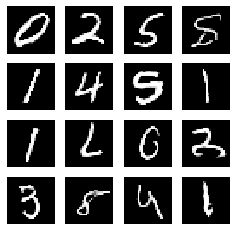

In [17]:
train(train_data, 300)

In [18]:
import shutil
shutil.make_archive('train_figs', 'zip', 'train_figs')

'/content/train_figs.zip'